#Install and Import Libraries

In [ ]:
!pip install -q torch optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 16.8 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

In [ ]:
import random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Load dataset

In [ ]:
dataset = pd.read_csv("dataset_ACB_fullFeatures.csv")
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

In [ ]:
dataset = dataset.drop(columns=['ticker','field'])

In [ ]:
dataset.head()

,open,high,low,close,volume,RSI_14,MA_10,MA_50,MA_200,MACD,MACD_SIGNAL,MACD_HIST,ADX_14,STOCH_K,STOCH_D,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
date,,,,,,,,,,,,,,,,,,,
2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,50.370623,11195.08,11560.370,11299.0160,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,50.370623,11219.70,11554.462,11298.0695,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,40.306248,11209.85,11543.630,11295.7025,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,40.306248,11195.08,11531.814,11294.0930,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,34.004354,11165.54,11516.060,11291.1200,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


In [ ]:
numeric_vars = ['open','high','low','close','volume',
                'RSI_14','MA_10','MA_50','MA_200',
                'MACD','MACD_SIGNAL','MACD_HIST','ADX_14',
                'STOCH_K','STOCH_D','STOCHRSI_14',
                'GDP × 10^9 (USD)','CPI','usd_vnd']
for var in numeric_vars:
  dataset[var] = pd.to_numeric(dataset[var], errors='coerce')

In [ ]:
dataset.shape, dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2020-01-02 to 2025-10-20
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open              1442 non-null   float64
 1   high              1442 non-null   float64
 2   low               1442 non-null   float64
 3   close             1442 non-null   float64
 4   volume            1442 non-null   float64
 5   RSI_14            1442 non-null   float64
 6   MA_10             1442 non-null   float64
 7   MA_50             1442 non-null   float64
 8   MA_200            1442 non-null   float64
 9   MACD              1442 non-null   float64
 10  MACD_SIGNAL       1442 non-null   float64
 11  MACD_HIST         1442 non-null   float64
 12  ADX_14            1442 non-null   float64
 13  STOCH_K           1442 non-null   float64
 14  STOCH_D           1442 non-null   float64
 15  STOCHRSI_14       1442 non-null   float64
 16  GDP × 10^9 (USD)  1442 n

((1442, 19), None)

In [ ]:
dataset.head()

,open,high,low,close,volume,RSI_14,MA_10,MA_50,MA_200,MACD,MACD_SIGNAL,MACD_HIST,ADX_14,STOCH_K,STOCH_D,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
date,,,,,,,,,,,,,,,,,,,
2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,50.370623,11195.08,11560.370,11299.0160,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,50.370623,11219.70,11554.462,11298.0695,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,40.306248,11209.85,11543.630,11295.7025,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,40.306248,11195.08,11531.814,11294.0930,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,34.004354,11165.54,11516.060,11291.1200,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


In [ ]:
dataset.tail()

,open,high,low,close,volume,RSI_14,MA_10,MA_50,MA_200,MACD,MACD_SIGNAL,MACD_HIST,ADX_14,STOCH_K,STOCH_D,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
date,,,,,,,,,,,,,,,,,,,
2025-10-14,26750.0,26950.0,26250.0,26300.0,18530000.0,51.216729,26415.0,26204.0,24515.11,180.446749,105.341880,75.104869,18.401313,68.767507,82.375029,73.986440,476.39,0.0338,26355.5
2025-10-15,26400.0,26650.0,26150.0,26300.0,14420000.0,51.216729,26465.0,26264.0,24522.11,159.291041,116.131712,43.159329,17.997518,55.882353,79.545044,54.374705,476.39,0.0338,26340.0
2025-10-16,26400.0,26550.0,26150.0,26300.0,13460000.0,51.216729,26520.0,26321.0,24528.61,140.900773,121.085525,19.815249,17.622566,41.628959,71.967075,41.164793,476.39,0.0338,26335.0
2025-10-17,26300.0,26400.0,25750.0,25750.0,16290000.0,44.138220,26530.0,26352.0,24530.11,81.012093,113.070838,-32.058745,16.439502,25.942685,61.774726,27.443196,476.39,0.0338,26342.0
2025-10-20,25600.0,25650.0,24600.0,24800.0,32230000.0,35.111584,26330.0,26360.0,24526.36,-42.615928,81.933485,-124.549413,17.283909,12.820513,48.576097,13.721598,476.39,0.0338,26342.5


#Train / Valid/ Test Split and Preprocess

In [ ]:
data = dataset.copy()

# Lưu data gốc TRƯỚC KHI SCALE
data_original = data.copy()

train_ratio = 0.6
valid_ratio = 0.15

n = len(data)
train_end = int(train_ratio * n)
valid_end = int((train_ratio + valid_ratio) * n)

train_df = data.iloc[:train_end].copy()
valid_df = data.iloc[train_end:valid_end].copy()
test_df  = data.iloc[valid_end:].copy()

# Data gốc cho evaluation
train_df_original = data_original.iloc[:train_end].copy()
valid_df_original = data_original.iloc[train_end:valid_end].copy()
test_df_original  = data_original.iloc[valid_end:].copy()

print(f"Total: {n}")
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Total: 1442
Train: 865, Valid: 216, Test: 361


In [ ]:
# Features dùng RobustScaler (KHÔNG bao gồm close)
features_robust = ['open','high','low','volume',
                'RSI_14','MA_10','MA_50','MA_200',
                'MACD','MACD_SIGNAL','MACD_HIST','ADX_14',
                'STOCH_K','STOCH_D','STOCHRSI_14',
                'GDP × 10^9 (USD)','CPI','usd_vnd']

# RobustScaler cho các features khác
scaler_robust = RobustScaler().fit(train_df[features_robust])

train_df[features_robust] = scaler_robust.transform(train_df[features_robust])
valid_df[features_robust] = scaler_robust.transform(valid_df[features_robust])
test_df[features_robust]  = scaler_robust.transform(test_df[features_robust])

#StandardScaler cho close
scaler_close = StandardScaler().fit(train_df[['close']])

train_df['close'] = scaler_close.transform(train_df[['close']])
valid_df['close'] = scaler_close.transform(valid_df[['close']])
test_df['close']  = scaler_close.transform(test_df[['close']])

print(f"\nScaling summary:")
print(f"  RobustScaler: {features_robust}")
print(f"  StandardScaler: ['close']")


Scaling summary:
  RobustScaler: ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']
  StandardScaler: ['close']


# Dataset class

In [ ]:
class StockDataset(Dataset):
    def __init__(self, df, df_original, feature_cols, horizons=[1, 4, 8, 12, 24], window=36):
        """
        Args:
            df: DataFrame đã được scale
            df_original: DataFrame GỐC (chưa scale) để lấy giá thực
            feature_cols: Các cột feature (bao gồm pct_change)
            horizons: Các horizon cần dự đoán
            window: Số ngày lookback (L)
        """
        self.samples = []
        self.horizons = horizons

        features = df[feature_cols].values
        close_original = df_original['close'].values  # Giá GỐC chưa scale

        n = len(df)
        for i in range(n - window - max(horizons)):
            X = features[i : i + window]

            # Base price GỐC (ngày cuối window)
            base_price = close_original[i + window - 1]

            # Target: cumulative pct_change từ ngày L đến ngày L+H
            y = []
            actual_prices = []
            for h in horizons:
                future_price = close_original[i + window + h - 1]
                cumulative_return = (future_price - base_price) / base_price if base_price != 0 else 0
                y.append(cumulative_return)
                actual_prices.append(future_price)

            self.samples.append((X, y, base_price, actual_prices))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y, base_price, actual_prices = self.samples[idx]
        return (torch.tensor(X, dtype=torch.float32),
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(base_price, dtype=torch.float32),
                torch.tensor(actual_prices, dtype=torch.float32))

#Model LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2,
                 num_horizons=5, dropout=0.3):
        super(LSTM, self).__init__()

        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_horizons)
        )

    def forward(self, x):
        out, _ = self.encoder(x)
        context = out[:, -1, :]
        return self.fc(context)

#EarlyStopping class

In [ ]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0
        self.best_state = None

    def step(self, metric, model):
        improved = (self.best is None) or (metric < self.best - self.min_delta)
        if improved:
            self.best = metric
            self.count = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
        return improved, self.count >= self.patience

#Optimize Hyperparameters

In [ ]:
feature_cols = features_robust + ['close']
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (19): ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd', 'close']


In [ ]:
H_LIST = [1, 4, 7, 10, 14, 21]

In [ ]:
best_L = None
best_valid_loss = float('inf')
best_model_state = None
results_by_L = {}

In [ ]:
def objective(trial):
    # Hyperparameters cần tối ưu
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
    L = trial.suggest_categorical('L', [12, 24, 36, 48, 60, 72, 84, 96])

    # Tạo dataset
    train_dataset = StockDataset(train_df, train_df_original, feature_cols, horizons=H_LIST, window=L)
    valid_dataset = StockDataset(valid_df, valid_df_original, feature_cols, horizons=H_LIST, window=L)

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        raise optuna.TrialPruned()

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    # Tạo model
    model = LSTM(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_horizons=len(H_LIST),
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    # Training loop
    for epoch in range(1, 51):
        model.train()
        for X_batch, y_batch, _, _ in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch, _, _ in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_loss += criterion(model(X_batch), y_batch).item()
        val_loss /= len(valid_loader)

        # Pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        improved, should_stop = early_stopping.step(val_loss, model)
        if should_stop:
            break

    return early_stopping.best

In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Kết quả
print(f"\n{'='*50}")
print(f"BEST PARAMS:")
print(f"  hidden_dim: {study.best_params['hidden_dim']}")
print(f"  num_layers: {study.best_params['num_layers']}")
print(f"  dropout: {study.best_params['dropout']}")
print(f"  L: {study.best_params['L']}")
print(f"  Valid Loss: {study.best_value:.6f}")

[I 2025-12-16 10:50:05,504] A new study created in memory with name: no-name-9f77ae2b-91c5-471a-8ea4-169e2431d15a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 10:50:20,512] Trial 0 finished with value: 0.0016508973785676062 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.1, 'L': 72}. Best is trial 0 with value: 0.0016508973785676062.
[I 2025-12-16 10:50:26,012] Trial 1 finished with value: 0.0035260870354250073 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.2, 'L': 72}. Best is trial 0 with value: 0.0016508973785676062.
[I 2025-12-16 10:50:27,503] Trial 2 finished with value: 0.0023161720212859413 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.5, 'L': 12}. Best is trial 0 with value: 0.0016508973785676062.
[I 2025-12-16 10:50:28,335] Trial 3 finished with value: 0.001628295297268778 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.30000000000000004, 'L': 36}. Best is trial 3 with value: 0.001628295297268778.
[I 2025-12-16 10:50:30,787] Trial 4 finished with value: 0.003158570150844753 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.2, 'L': 

#Training Loops, khởi tạo dataset, dataloader, model và tìm L tốt nhất

In [ ]:
L_VALUES = [12, 24, 36, 48, 60, 72, 84, 96]
H_LIST = [1, 4, 7, 10, 14, 21]

In [ ]:
feature_cols = features_robust + ['close']
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (19): ['open', 'high', 'low', 'volume', 'RSI_14', 'MA_10', 'MA_50', 'MA_200', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX_14', 'STOCH_K', 'STOCH_D', 'STOCHRSI_14', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd', 'close']


In [ ]:
best_L = None
best_valid_loss = float('inf')
best_model_state = None
results_by_L = {}

In [ ]:
for L in L_VALUES:
    print(f"\n{'='*60}")
    print(f"TRAINING WITH L = {L}")
    print(f"{'='*60}")

    train_dataset = StockDataset(train_df, train_df_original, feature_cols, horizons=H_LIST, window=L)
    valid_dataset = StockDataset(valid_df, valid_df_original, feature_cols, horizons=H_LIST, window=L)

    print(f"Train samples: {len(train_dataset)}, Valid samples: {len(valid_dataset)}")

    if len(train_dataset) < 10 or len(valid_dataset) < 5:
        print(f"Skipping L={L}: Not enough samples")
        continue

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    model = LSTM(
        input_dim=len(feature_cols),
        hidden_dim=32,
        num_layers=3,
        num_horizons=len(H_LIST),
        dropout=0.1
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    early_stopping = EarlyStopping(patience=7, min_delta=1e-5)

    EPOCHS = 100
    train_losses, valid_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        # Training
        model.train()
        running_train = 0.0
        for X_batch, y_batch, _, _ in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_train += loss.item()

        epoch_train_loss = running_train / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_valid = 0.0
        with torch.no_grad():
            for X_batch, y_batch, _, _ in valid_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                running_valid += loss.item()

        epoch_valid_loss = running_valid / len(valid_loader)
        valid_losses.append(epoch_valid_loss)

        scheduler.step(epoch_valid_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Train: {epoch_train_loss:.6f} | Valid: {epoch_valid_loss:.6f}")

        improved, should_stop = early_stopping.step(epoch_valid_loss, model)
        if should_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    if early_stopping.best_state is not None:
        model.load_state_dict(early_stopping.best_state)

    final_valid_loss = early_stopping.best
    results_by_L[L] = {
        'valid_loss': final_valid_loss,
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'epochs_trained': len(train_losses)
    }

    print(f"L={L} -> Best Valid Loss: {final_valid_loss:.6f}")

    if final_valid_loss < best_valid_loss:
        best_valid_loss = final_valid_loss
        best_L = L
        best_model_state = early_stopping.best_state.copy()

print(f"\n{'='*60}")
print(f"BEST L = {best_L} with Valid Loss = {best_valid_loss:.6f}")
print(f"{'='*60}")


TRAINING WITH L = 12
Train samples: 832, Valid samples: 183
Epoch  10 | Train: 0.003852 | Valid: 0.002733
Early stopping at epoch 10
L=12 -> Best Valid Loss: 0.001484

TRAINING WITH L = 24
Train samples: 820, Valid samples: 171
Early stopping at epoch 9
L=24 -> Best Valid Loss: 0.001470

TRAINING WITH L = 36
Train samples: 808, Valid samples: 159
Early stopping at epoch 8
L=36 -> Best Valid Loss: 0.001513

TRAINING WITH L = 48
Train samples: 796, Valid samples: 147
Early stopping at epoch 9
L=48 -> Best Valid Loss: 0.001817

TRAINING WITH L = 60
Train samples: 784, Valid samples: 135
Early stopping at epoch 8
L=60 -> Best Valid Loss: 0.001458

TRAINING WITH L = 72
Train samples: 772, Valid samples: 123
Early stopping at epoch 9
L=72 -> Best Valid Loss: 0.001706

TRAINING WITH L = 84
Train samples: 760, Valid samples: 111
Epoch  10 | Train: 0.002686 | Valid: 0.007151
Early stopping at epoch 10
L=84 -> Best Valid Loss: 0.001994

TRAINING WITH L = 96
Train samples: 748, Valid samples: 99

#Plot

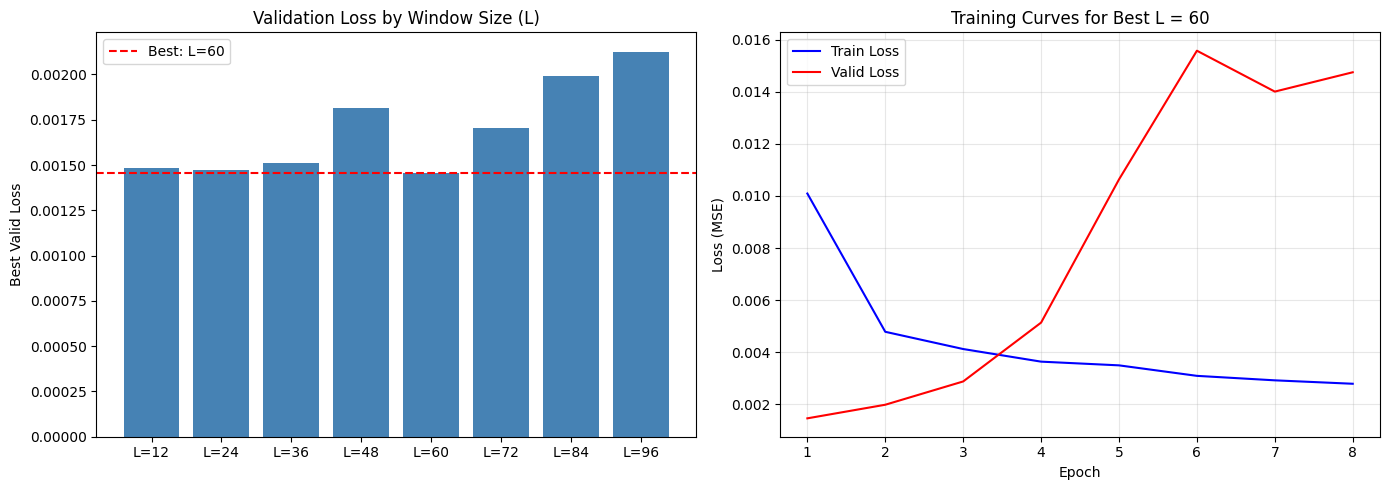

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: So sánh valid loss các L
L_list = list(results_by_L.keys())
valid_losses_list = [results_by_L[L]['valid_loss'] for L in L_list]

axes[0].bar(range(len(L_list)), valid_losses_list, color='steelblue')
axes[0].set_xticks(range(len(L_list)))
axes[0].set_xticklabels([f'L={L}' for L in L_list])
axes[0].set_ylabel('Best Valid Loss')
axes[0].set_title('Validation Loss by Window Size (L)')
axes[0].axhline(y=best_valid_loss, color='red', linestyle='--', label=f'Best: L={best_L}')
axes[0].legend()

# Plot 2: Training curves for best L
best_train_losses = results_by_L[best_L]['train_losses']
best_valid_losses_plot = results_by_L[best_L]['valid_losses']
epochs_trained = results_by_L[best_L]['epochs_trained']

axes[1].plot(range(1, epochs_trained + 1), best_train_losses, 'b-', label='Train Loss')
axes[1].plot(range(1, epochs_trained + 1), best_valid_losses_plot, 'r-', label='Valid Loss')

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_title(f'Training Curves for Best L = {best_L}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#ĐÁNH GIÁ TRÊN Test SET VỚI BEST L

In [ ]:
print(f"\n{'='*60}")
print(f"EVALUATING ON TEST SET WITH BEST L = {best_L}")
print(f"{'='*60}")

# Tạo test dataset
test_dataset = StockDataset(
    test_df, test_df_original, feature_cols,
    horizons=H_LIST, window=best_L
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test samples: {len(test_dataset)}")

# Load best model
model = LSTM(
    input_dim=len(feature_cols),
    hidden_dim=32,
    num_layers=3,
    num_horizons=len(H_LIST),
    dropout=0.1
).to(device)
model.load_state_dict(best_model_state)
model.eval()

# Collect predictions
all_y_true = []
all_y_pred = []
all_base_prices = []
all_actual_prices = []

with torch.no_grad():
    for X_batch, y_batch, base_prices, actual_prices in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()

        all_y_true.append(y_batch.numpy())
        all_y_pred.append(preds)
        all_base_prices.append(base_prices.numpy())
        all_actual_prices.append(actual_prices.numpy())

all_y_true = np.concatenate(all_y_true, axis=0)
all_y_pred = np.concatenate(all_y_pred, axis=0)
all_base_prices = np.concatenate(all_base_prices, axis=0)
all_actual_prices = np.concatenate(all_actual_prices, axis=0)


EVALUATING ON TEST SET WITH BEST L = 60
Test samples: 280


#DỰ ĐOÁN THỬ

In [ ]:
print("\n=== TEST SET RESULTS (ACTUAL PRICE - VND) ===")

# Chuyển pct_change về giá: close_H = close_L + (close_L * pct_change)
pred_prices = np.zeros_like(all_y_pred)
for i in range(len(all_base_prices)):
    for j in range(len(H_LIST)):
        delta = all_base_prices[i] * all_y_pred[i, j]
        pred_prices[i, j] = all_base_prices[i] + delta

for i, h in enumerate(H_LIST):
    actual = all_actual_prices[:, i]
    pred   = pred_prices[:, i]

    # Mean price (dùng để scale về 0–1)
    mean_price = actual.mean()

    # Metrics gốc (VND)
    mae  = mean_absolute_error(actual, pred)            # VND
    rmse = np.sqrt(mean_squared_error(actual, pred))    # VND
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    r2   = r2_score(actual, pred)

    # Metrics normalized (0 → 1)
    mae_norm  = mae / mean_price
    rmse_norm = rmse / mean_price

    # Print tất cả 6 metrics
    print(
        f"H={h:3d}: "
        f"MAE={mae:,.2f} VND | "
        f"RMSE={rmse:,.2f} VND | "
        f"MAE_norm={mae_norm:.5f} | "
        f"RMSE_norm={rmse_norm:.5f} | "
        f"MAPE={mape:.2f}% | "
        f"R2={r2:.5f}"
    )


=== TEST SET RESULTS (ACTUAL PRICE - VND) ===
H=  1: MAE=290.25 VND | RMSE=501.96 VND | MAE_norm=0.01181 | RMSE_norm=0.02043 | MAPE=1.17% | R2=0.91286
H=  4: MAE=557.55 VND | RMSE=900.45 VND | MAE_norm=0.02267 | RMSE_norm=0.03661 | MAPE=2.28% | R2=0.71908
H=  7: MAE=687.69 VND | RMSE=1,081.56 VND | MAE_norm=0.02794 | RMSE_norm=0.04394 | MAPE=2.81% | R2=0.59496
H= 10: MAE=852.26 VND | RMSE=1,248.24 VND | MAE_norm=0.03459 | RMSE_norm=0.05067 | MAPE=3.48% | R2=0.46090
H= 14: MAE=1,015.75 VND | RMSE=1,472.11 VND | MAE_norm=0.04118 | RMSE_norm=0.05968 | MAPE=4.15% | R2=0.26154
H= 21: MAE=1,324.24 VND | RMSE=1,787.84 VND | MAE_norm=0.05358 | RMSE_norm=0.07234 | MAPE=5.40% | R2=-0.05941


In [ ]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS (Last 5 samples)")
print("="*70)

for sample_idx in range(-5, 0):
    base = all_base_prices[sample_idx]
    print(f"\n📊 Sample {sample_idx}: Base Price = {base:,.0f} VND")
    print("-" * 60)

    for i, h in enumerate(H_LIST):
        actual_price = all_actual_prices[sample_idx, i]
        pred_pct = all_y_pred[sample_idx, i]

        # Tính giá dự đoán: base + (base * pct_change)
        delta = base * pred_pct
        pred_price = base + delta

        error = abs(actual_price - pred_price)
        error_pct = error / actual_price * 100

        direction = "📈" if pred_pct > 0 else "📉"

        print(f"  H={h:3d}: pct_change={pred_pct:+.4f} ({pred_pct*100:+.2f}%) {direction}")
        print(f"         Delta={delta:+,.0f} VND")
        print(f"         Actual={actual_price:>10,.0f} VND | Pred={pred_price:>10,.0f} VND | Error={error:>8,.0f} VND ({error_pct:.2f}%)")


SAMPLE PREDICTIONS (Last 5 samples)

📊 Sample -5: Base Price = 26,300 VND
------------------------------------------------------------
  H=  1: pct_change=+0.0228 (+2.28%) 📈
         Delta=+599 VND
         Actual=    26,400 VND | Pred=    26,899 VND | Error=     499 VND (1.89%)
  H=  4: pct_change=+0.0188 (+1.88%) 📈
         Delta=+495 VND
         Actual=    25,550 VND | Pred=    26,795 VND | Error=   1,245 VND (4.87%)
  H=  7: pct_change=+0.0039 (+0.39%) 📈
         Delta=+102 VND
         Actual=    25,350 VND | Pred=    26,402 VND | Error=   1,052 VND (4.15%)
  H= 10: pct_change=+0.0158 (+1.58%) 📈
         Delta=+415 VND
         Actual=    25,650 VND | Pred=    26,715 VND | Error=   1,065 VND (4.15%)
  H= 14: pct_change=+0.0113 (+1.13%) 📈
         Delta=+298 VND
         Actual=    25,750 VND | Pred=    26,598 VND | Error=     848 VND (3.29%)
  H= 21: pct_change=-0.0185 (-1.85%) 📉
         Delta=-486 VND
         Actual=    26,750 VND | Pred=    25,814 VND | Error=     936 VND (3

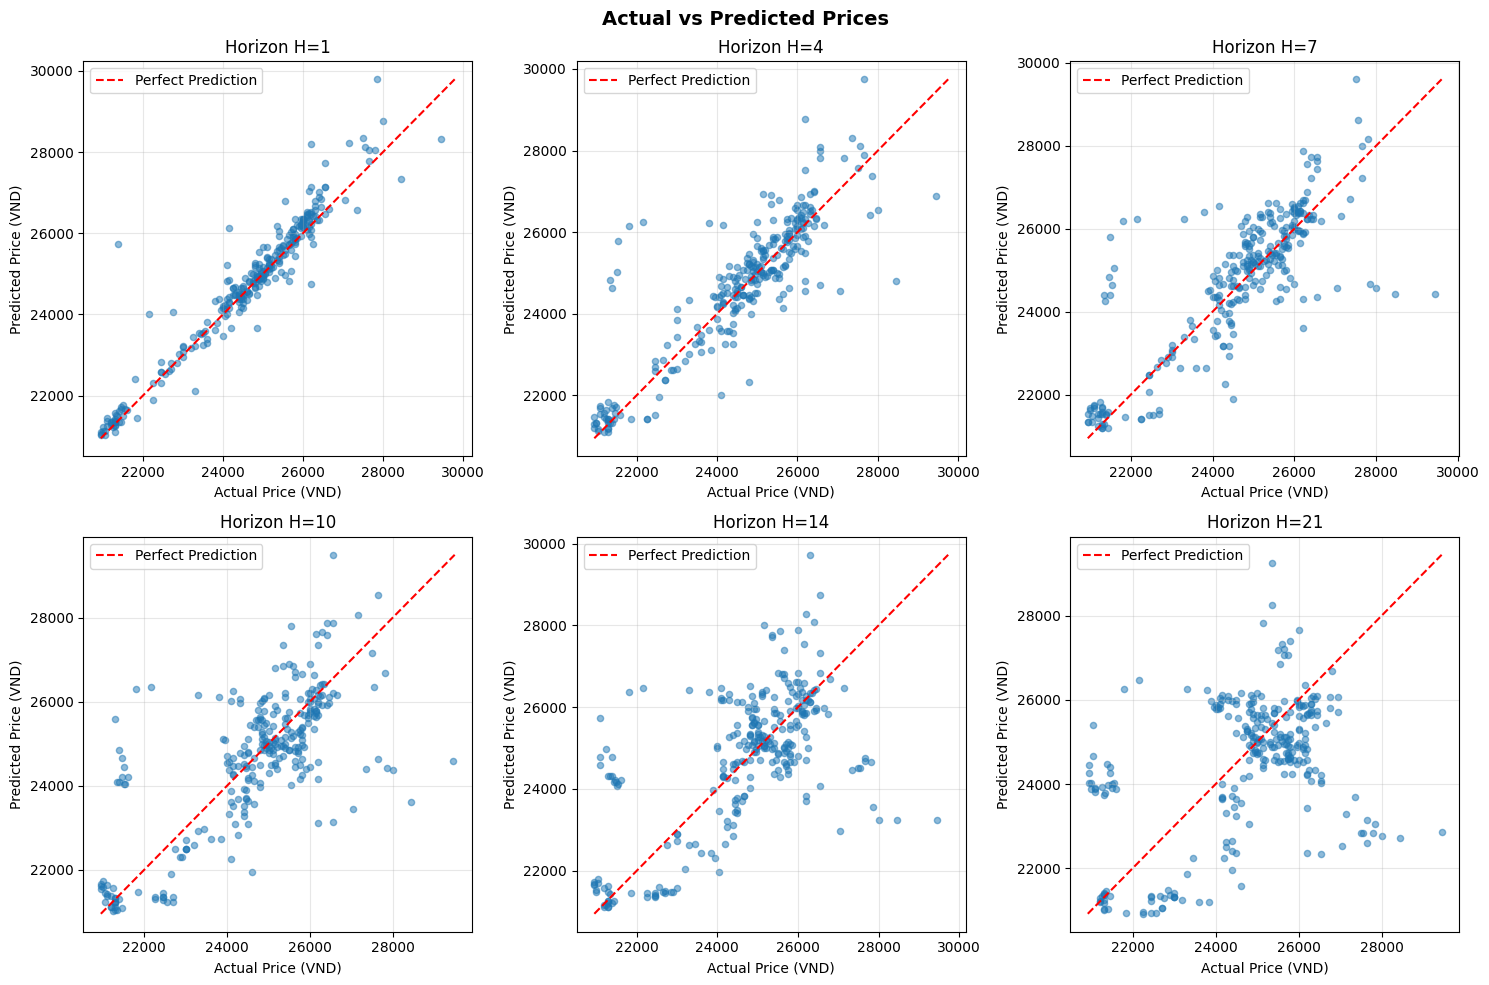

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, h in enumerate(H_LIST):
    if i >= len(axes):
        break

    actual = all_actual_prices[:, i]
    pred = pred_prices[:, i]

    axes[i].scatter(actual, pred, alpha=0.5, s=20)

    # Đường perfect prediction
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

    axes[i].set_xlabel('Actual Price (VND)')
    axes[i].set_ylabel('Predicted Price (VND)')
    axes[i].set_title(f'Horizon H={h}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Ẩn subplot thừa
if len(H_LIST) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

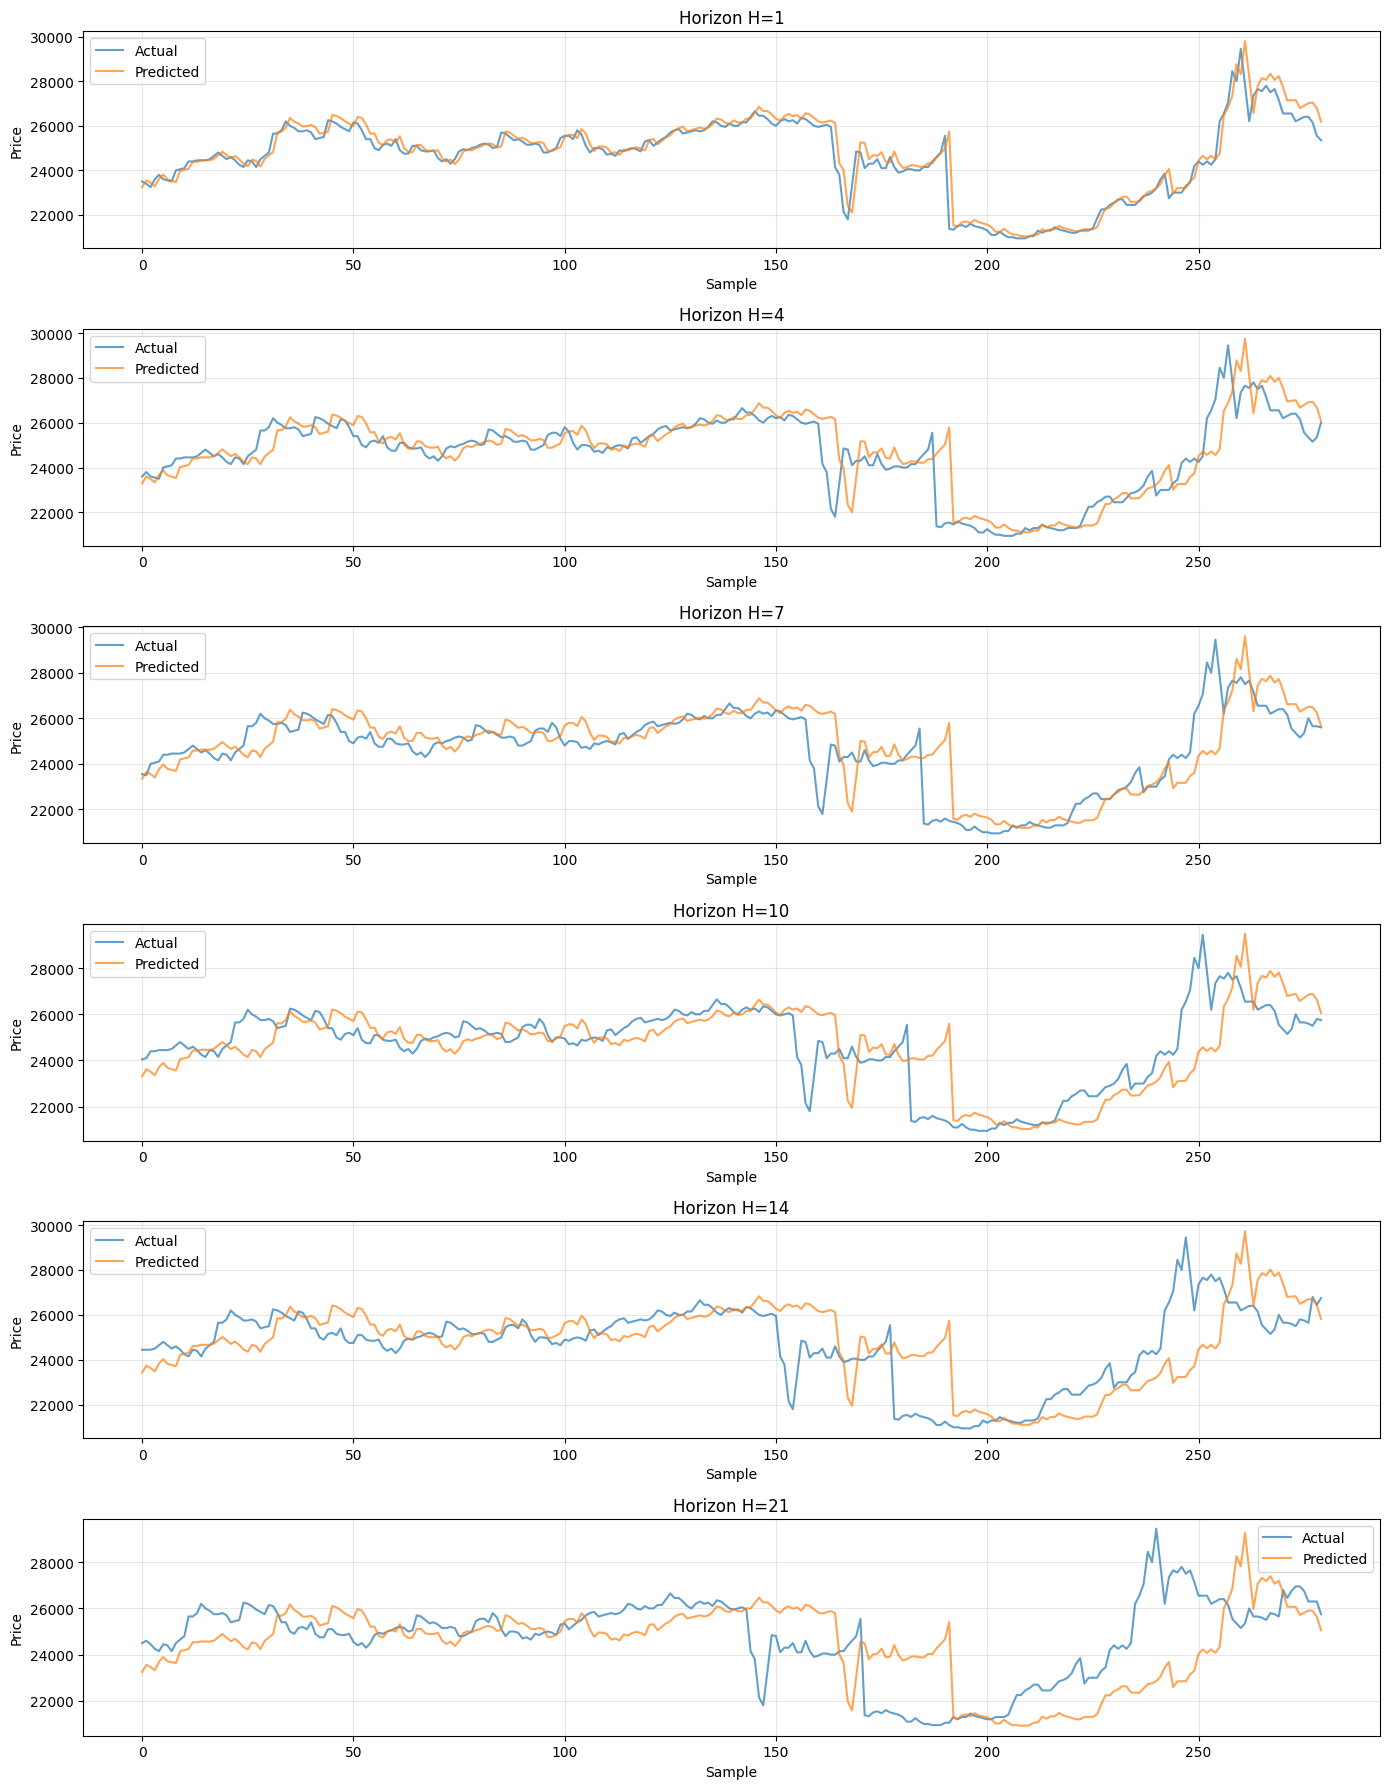

In [ ]:
# Plot predictions vs actual cho một vài horizons
fig, axes = plt.subplots(len(H_LIST), 1, figsize=(14, 3*len(H_LIST)))

for i, h in enumerate(H_LIST):
    ax = axes[i] if len(H_LIST) > 1 else axes

    pred_prices = all_base_prices * (1 + all_y_pred[:, i])
    actual_prices = all_actual_prices[:, i]

    ax.plot(actual_prices, label='Actual', alpha=0.7)
    ax.plot(pred_prices, label='Predicted', alpha=0.7)
    ax.set_title(f'Horizon H={h}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Save model

In [ ]:
torch.save({
    'model_state_dict': best_model_state,
    'best_L': best_L,
    'scaler_robust': scaler_robust,
    'scaler_close': scaler_close,
    'features_robust': features_robust,
    'feature_cols': feature_cols,
    'horizons': H_LIST
}, f'best_lstm_Fullfts_L{best_L}.pth')

print(f"\nModel saved as 'best_lstm_Fullfts_L{best_L}.pth'")


Model saved as 'best_lstm_Fullfts_L60.pth'
